In [26]:
import cv2
import numpy as np
import seaborn as sns
from time import time
from tqdm import tqdm
import h5py

from line_junction_utils import *
from robust_line_based_estimator.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches, plot_matches

In [27]:
# Parameters
matcher_type = "lbd" # "sold2"
dataset_path = "/media/hdd2tb/datasets/RANSAC-Tutorial-Data/train"
output_path = "."
threshold = 3 # Threshold in pixels
scenes = [ "buckingham_palace" ]

In [28]:
# Initializing the line matcher
if matcher_type == "lbd":
    # LSD+LBD matcher
    matcher = LineMatcher(line_detector='lsd', line_matcher='lbd')
else:
    # SOLD2 matcher
    conf = {
        'sold2': {
            'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
            'device': 'cpu'
        }
    }
    matcher = LineMatcher(line_detector='sold2', line_matcher='sold2', conf=conf)

In [29]:
def processingScene(dataset_path, feature_matches, K1_K2, R, T, matcher, linefile_path, matchfile_path, threshold, visualize=0):
    cnt = 0
    for k, m in tqdm(feature_matches.items(), disable = visualize > 0):
        img_id0 = k.split('-')[0]
        img_id1 = k.split('-')[1]

        img0 = cv2.imread(f"{dataset_path}/images/{img_id0}.jpg", 0)
        img1 = cv2.imread(f"{dataset_path}/images/{img_id1}.jpg", 0)

        ## Detecting line segments in the first image
        features0_segments = read_h5(f"img-{img_id0}-line-segments", linefile_path)
        features0_descs = read_h5(f"img-{img_id0}-descriptor", linefile_path)
        features0_ms_lines = read_h5(f"img-{img_id0}-ms_lines", linefile_path)
        if features0_segments is None:
            features0 = matcher.detect_and_describe_lines(img0)
            append_h5({f"img-{img_id0}-line-segments": features0["line_segments"],
                f"img-{img_id0}-descriptor": features0["descriptor"], 
                f"img-{img_id0}-ms_lines": convert_ms_lines(features0["ms_lines"])}, 
                linefile_path)
        else:
            features0 = { "line_segments": features0_segments, 
                "descriptor": features0_descs,
                "ms_lines": parse_ms_lines(features0_ms_lines) }
         
        # Detecting line segments in the second image
        features1_segments = read_h5(f"img-{img_id1}-line-segments", linefile_path)
        features1_descs = read_h5(f"img-{img_id1}-descriptor", linefile_path)
        features1_ms_lines = read_h5(f"img-{img_id1}-ms_lines", linefile_path)
        if features1_segments is None:
            features1 = matcher.detect_and_describe_lines(img1)
            append_h5({f"img-{img_id1}-line-segments": features1["line_segments"],
                f"img-{img_id1}-descriptor": features1["descriptor"], 
                f"img-{img_id1}-ms_lines": convert_ms_lines(features1["ms_lines"])}, 
                linefile_path)
        else:
            features1 = { "line_segments": features1_segments, 
                "descriptor": features1_descs,
                "ms_lines": parse_ms_lines(features1_ms_lines) }

        if visualize > 0 and False:
            # Display the detections
            plot_images([img0, img1], ['Detections 0', 'Detections 1'])
            plot_lines([features0["line_segments"][:, :, [1, 0]], features1["line_segments"][:, :, [1, 0]]])

        ## Matching
        m_lines0 = read_h5(f"{img_id0}-{img_id1}-m_lines0", matchfile_path)
        m_lines1 = read_h5(f"{img_id0}-{img_id1}-m_lines1", matchfile_path)
        if m_lines0 is None:
            _, m_lines0, m_lines1 = matcher.match_lines(img0, img1, features0, features1)
            append_h5({f"{img_id0}-{img_id1}-m_lines0": m_lines0,
                f"{img_id0}-{img_id1}-m_lines1": m_lines1}, 
                matchfile_path)

        # Get all possible line junctions
        keypoints1, keypoints2 = get_line_junctions(m_lines0, m_lines1)

        # Normalize the obtained keypoints by the camera matrix
        K1 = K1_K2[k][0][0]
        K2 = K1_K2[k][0][1]
        kp1n = normalize_keypoints(keypoints1, K1).astype(np.float64)
        kp2n = normalize_keypoints(keypoints2, K2).astype(np.float64)

        # Normalizing the threshold by the camera matrices
        normalized_threshold = threshold / (0.25 * (K1[0, 0] + K1[1, 1] + K2[0, 0] + K2[1, 1]))

        # Composing the projection matrices from the rotations and translations
        R1 = R[img_id0]
        R2 = R[img_id1]
        T1 = T[img_id0]
        T2 = T[img_id1]
        
        P1 = np.concatenate([R1, T1], axis=1)
        P2 = np.concatenate([R2, T2], axis=1)

        # Checking each point's consistency with the camera poses by
        # triangulating them and, then, calculating the re-projection error.
        # for point_idx in range(kp1n.shape[0]):
        points3d, status = polynomial_triangulation(kp1n, P1, kp2n, P2)
        errors = reprojection_errors(kp1n, kp2n, points3d, P1, P2)

        inlier_mask = errors < normalized_threshold      

        if visualize > 0:
            print(f"Point number = {kp1n.shape[0]}")    
            print(f"Inlier number = {inlier_mask.sum()}")

            # Select points that fall inside the images
            points_inside1 = (keypoints1[:,1] >= 0) & (keypoints1[:,1] < img0.shape[1]) & (keypoints1[:,0] >= 0) & (keypoints1[:,0] < img0.shape[0])
            points_inside2 = (keypoints2[:,1] >= 0) & (keypoints2[:,1] < img1.shape[1]) & (keypoints2[:,0] >= 0) & (keypoints2[:,0] < img1.shape[0])
            points_inside = points_inside1 & points_inside2 & inlier_mask

            # Plot the matches
            plot_images([img0, img1], ['Keypoints 0', 'Keypoints 1'])
            plot_color_line_matches([m_lines0[:, :, [1, 0]], m_lines1[:, :, [1, 0]]])

            tmpKps1 = np.stack((keypoints1[points_inside, 1], keypoints1[points_inside, 0]), axis=1)
            tmpKps2 = np.stack((keypoints2[points_inside, 1], keypoints2[points_inside, 0]), axis=1)
            plot_matches(tmpKps1, tmpKps2)

            cnt += 1
            if cnt >= visualize:
                break


## Line detection and description

Point number = 1128
Inlier number = 1
Point number = 1711
Inlier number = 218
Point number = 9591
Inlier number = 444
Point number = 12561
Inlier number = 96
Point number = 7140
Inlier number = 39


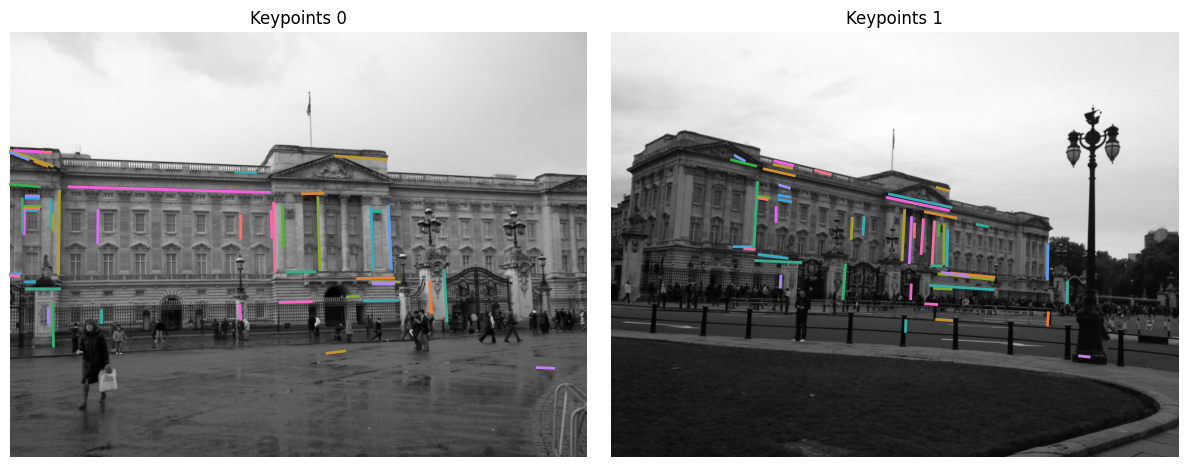

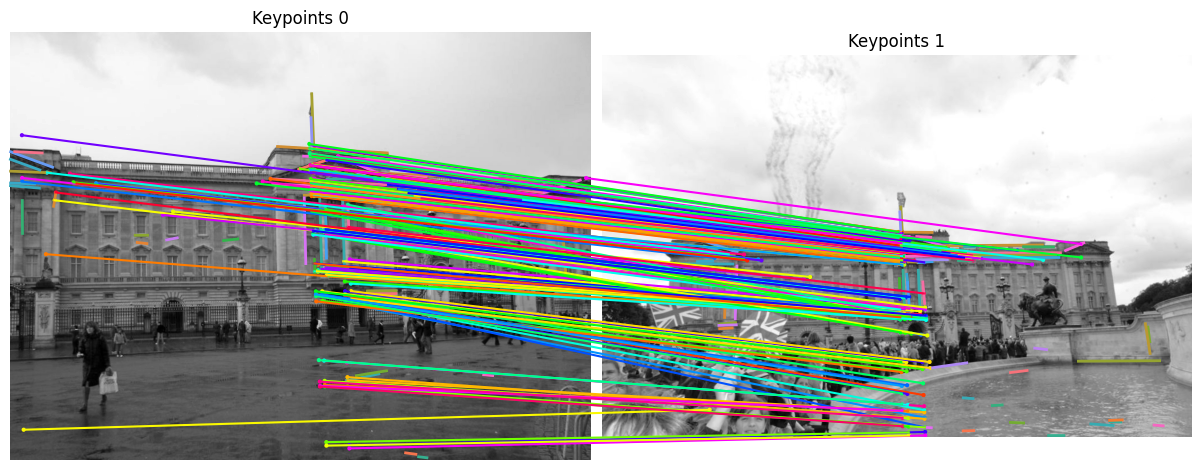

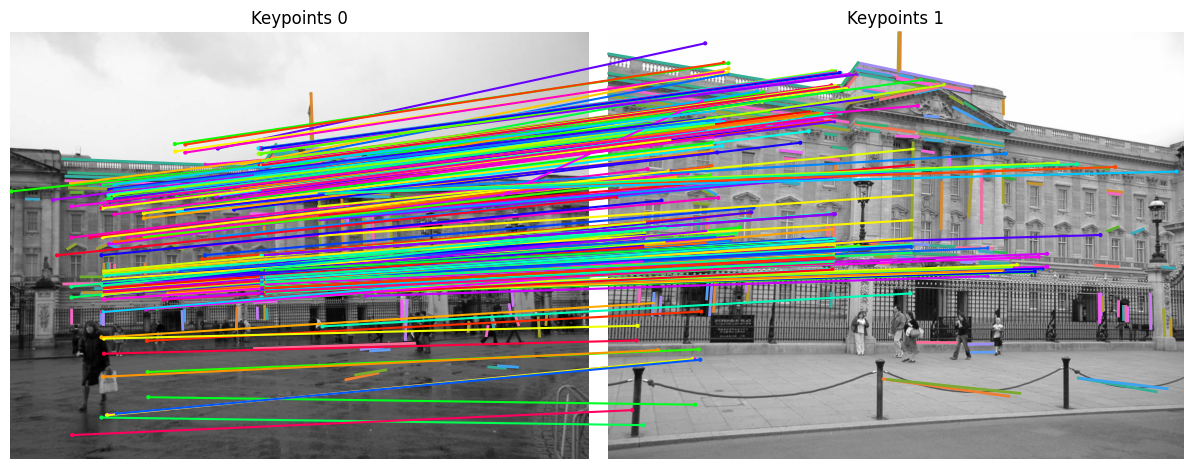

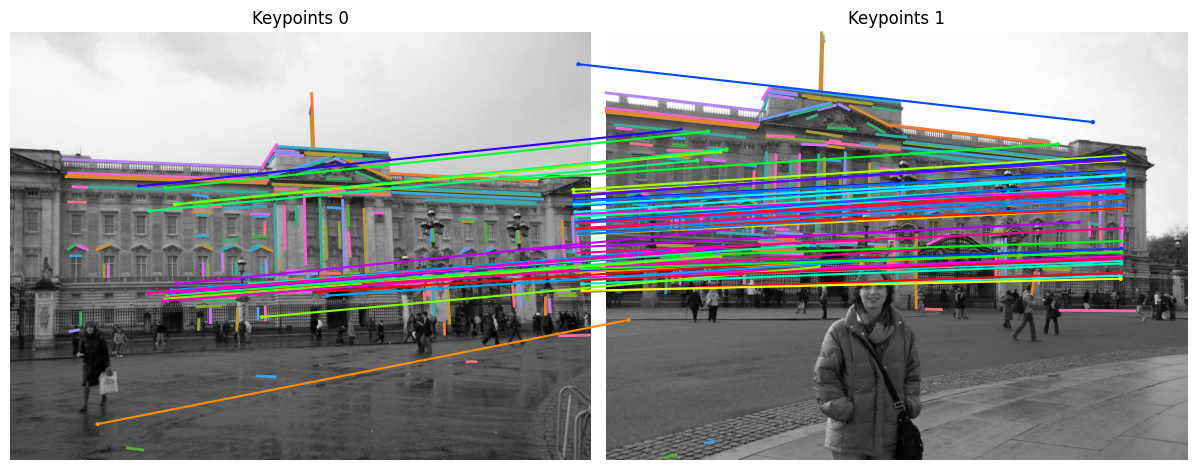

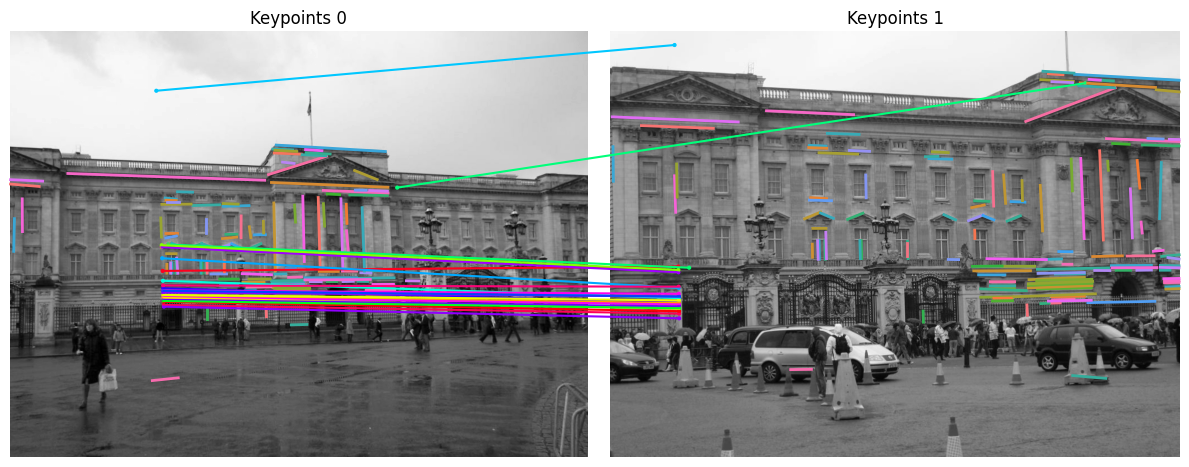

In [30]:
for scene in scenes:
    # Loading the camera parameters and the ground truth pose
    #K1_K2 = load_h5(f'{dataset_path}/{scene}/K1_K2.h5')
    #R = load_h5(f'{dataset_path}/{scene}/R.h5')
    #T = load_h5(f'{dataset_path}/{scene}/T.h5')
    #feature_matches = load_h5(f'{dataset_path}/{scene}/matches.h5')
    # Iterating through the image pairs in the scene
    processingScene(f'{dataset_path}/{scene}', 
        feature_matches,
        K1_K2, 
        R, 
        T, 
        matcher, 
        f"{output_path}/lines_{scene}.h5", 
        f"{output_path}/matches_{scene}.h5", 
        threshold,
        visualize=5)
    